In [2]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import cross_validate
import time
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import time
import torch.optim as optim
import random
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

## Read Data

Define the **DATA_PATH**, where the train, test and val datasets are located

In [3]:
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/ML/project_3/music_genre_data_di/"

Mounted at /content/drive


In [4]:
mfs = 'mfccs/'
melgs = 'melgrams/'
test = 'test/'
train = 'train/'
val = 'val/'
train = 'train/'
labels = 'labels.npy'
x = 'X.npy'

Reproducability

In [5]:
seed = 42

In [7]:
def set_seeds(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

Load MFCCs and mel-spectograms train, test and val datasets

In [8]:
test_mfs_x = np.load(DATA_PATH + test + mfs + x)
test_y = np.load(DATA_PATH + test + mfs + labels)
test_melgs_x = np.load(DATA_PATH + test + melgs + x)

train_mfs_x = np.load(DATA_PATH + train + mfs + x)
train_y = np.load(DATA_PATH + train + mfs + labels)
train_melgs_x = np.load(DATA_PATH + train + melgs + x)

val_mfs_x = np.load(DATA_PATH + val + mfs + x)
val_y = np.load(DATA_PATH + val + mfs + labels)
val_melgs_x = np.load(DATA_PATH + val + melgs + x)

In [9]:
print('Test data:')
print(f'  mfccs.X.shape: {test_mfs_x.shape}')
print(f'  melgrams.y.shape: {test_melgs_x.shape}')
print(f'  mfccs.y.shape: {test_y.shape}')

print('Train data:')
print(f'  mfccs.X.shape: {train_mfs_x.shape}')
print(f'  melgrams.y.shape: {train_melgs_x.shape}')
print(f'  mfccs.y.shape: {train_y.shape}')

print('Validation data:')
print(f'  mfccs.X.shape: {val_mfs_x.shape}')
print(f'  melgrams.y.shape: {val_melgs_x.shape}')
print(f'  mfccs.y.shape: {val_y.shape}')


Test data:
  mfccs.X.shape: (1376, 26)
  melgrams.y.shape: (1376, 21, 128)
  mfccs.y.shape: (1376,)
Train data:
  mfccs.X.shape: (3200, 26)
  melgrams.y.shape: (3200, 21, 128)
  mfccs.y.shape: (3200,)
Validation data:
  mfccs.X.shape: (800, 26)
  melgrams.y.shape: (800, 21, 128)
  mfccs.y.shape: (800,)


Map string labels to integers

In [10]:
all_labels = np.concatenate((test_y, train_y, val_y))
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

test_y = label_encoder.transform(test_y)
train_y = label_encoder.transform(train_y)
val_y = label_encoder.transform(val_y)

In [11]:
dist_labels = label_encoder.classes_

## Utils

In [12]:
class Dataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, index):
        x = self.x_data[index]
        y = self.y_data[index]
        return torch.tensor(x), torch.tensor(y)

    def __len__(self):
        return self.x_data.shape[0]

In [13]:
def get_accuracy(y_true, y_pred):
  y_pred = y_pred.argmax(dim=1)
  correct = (y_true == y_pred).float()
  accuracy = correct.sum() / len(correct)
  return accuracy

In [14]:
#Plots train_losses, val_losses, train_accuracies, val_accuracies per n_epochs
def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies, n_epochs, append_to_tile=""):
  plt.style.use("ggplot")
  plt.figure(figsize=(6, 4))

  plt.plot(np.arange(0, n_epochs), train_losses, label="train_loss")
  plt.plot(np.arange(0, n_epochs), val_losses, label="val_loss")
  plt.plot(np.arange(0, n_epochs), train_accuracies, label="train_acc")
  plt.plot(np.arange(0, n_epochs), val_accuracies, label="val_acc")
  plt.title("Training Loss and Accuracy" + append_to_tile)
  plt.xlabel("Epoch")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

## Ex. 1: Feedforward Neural Network

In [ ]:
test_mfs_dataset = Dataset(test_mfs_x, test_y)
train_mfs_dataset = Dataset(train_mfs_x, train_y)
val_mfs_dataset = Dataset(val_mfs_x, val_y)

In [ ]:
batch_size = 16
test_mfs_dataloader = DataLoader(test_mfs_dataset, batch_size=batch_size, shuffle=False)
train_mfs_dataloader = DataLoader(train_mfs_dataset, batch_size=batch_size, shuffle=True)
val_mfs_dataloader = DataLoader(val_mfs_dataset, batch_size=batch_size, shuffle=True)

### FFNN Model

Fully connected neural nework consisting of 4 levels with neuron numbers input_dim, 128, 32 and output_dim

In [ ]:
class FullyConnectedNN(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(FullyConnectedNN, self).__init__()
    self.flatten = nn.Flatten()

    self.model = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, output_dim),
    )

  def forward(self, x):
    x = self.flatten(x)
    return self.model(x)#pred

### Train - Evaluate

In [ ]:
def plot_confusion_matrix(confusion_matrix, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def get_f1_cf(y_true, y_pred):
    y_pred = y_pred.argmax(dim=1).cpu().numpy()
    y_true = y_true.cpu().numpy()
    f1_weighted = f1_score(y_true, y_pred, average='macro')
    cf = confusion_matrix(y_true, y_pred, labels=range(4))
    return f1_weighted, cf

In [ ]:
#train the model on the training dataloader (for 1 epoch)
#returns average loss and average accuracy
def train(model, dataloader, optimizer, criterior):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        pred = model(X.float())
        loss = criterion(pred, y)
        acc = get_accuracy(y, pred)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
#evaluates the model on the validation dataset (for 1 epoch)
#returns average loss, average accuracy, average f1 score, average confusion matrix
def evaluate(model, dataloader, criterion):
  epoch_loss = 0
  epoch_acc = 0
  epoch_f1 = 0
  epoch_cf = np.zeros((4, 4)) # 4 are the total labels

  model.eval()
  with torch.no_grad():
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X.float())

        loss = criterion(pred, y)
        acc = get_accuracy(y, pred)
        f1, cf = get_f1_cf(y, pred)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1.item()
        epoch_cf += cf

  return epoch_loss / len(dataloader), epoch_acc / len(dataloader), epoch_f1 / len(dataloader), epoch_cf

In [ ]:
#train the model on the training dataloader
#evaluates the model on the validation dataloader
#returns lists of train loss and accuracy,
#valid loss, accuracy, f1, confusion matrix
def train_eval_model(model, epochs, optimizer, criterion, train_dataloader, validation_dataloader, classes=[], plot_cf=False):
  train_loss_list = []
  train_acc_list = []
  valid_loss_list = []
  valid_acc_list = []
  valid_f1_list = []
  cf_list = []

  for epoch in range(epochs):
    print(f'Epoch: {epoch+1:02}')
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1, valid_cf = evaluate(model, validation_dataloader, criterion)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    valid_f1_list.append(valid_f1)
    cf_list.append(valid_cf)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. F1: {valid_f1*100:.2f}%')
    if plot_cf:
      plot_confusion_matrix(valid_cf, classes)
  return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list, cf_list

* optimizer: stochastic gradient descent
* learning rate: 0.002
* loss function: cross-entropy loss
* αριθμός εποχών: 30

In [ ]:
D_in = test_mfs_x.shape[1]
D_out = 4
n_epochs = 30
criterion = nn.CrossEntropyLoss()
learning_rate = 0.002

Train - Evaluate (CPU)

In [ ]:
# device = 'cpu'

# model = FullyConnectedNN(D_in, D_out)
# model = model.to(device)
# print(model)

# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# start_time = time.time()
# train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list, valid_cf_list = train_eval_model(
#     model, n_epochs, optimizer, criterion, train_mfs_dataloader, val_mfs_dataloader
# )
# end_time = time.time()
# total_time = end_time-start_time
# total_time = "{:.3f}".format(total_time)

# print(f'Total execution time (CPU): {total_time}')

Train - Evaluate (GPU)

In [ ]:
if torch.cuda.is_available():
  print('Gpu available!')
  device = 'cuda'

model = FullyConnectedNN(D_in, D_out)
model = model.to(device)
print(model)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

if device == 'cuda':
  start_time = time.time()
  train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list, valid_cf_list = train_eval_model(
      model, n_epochs, optimizer, criterion, train_mfs_dataloader, val_mfs_dataloader
  )
  end_time = time.time()
  total_time = end_time-start_time
  total_time = "{:.3f}".format(total_time)

  print(f'Total execution time (GPU): {total_time}')
else:
  print('No available gpu...')

Gpu available!
FullyConnectedNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)
Epoch: 01
	Train Loss: 1.388 | Train Acc: 24.66%
	 Val. Loss: 1.377 |  Val. Acc: 34.62% | Val. F1: 27.03%
Epoch: 02
	Train Loss: 1.376 | Train Acc: 28.78%
	 Val. Loss: 1.387 |  Val. Acc: 25.00% | Val. F1: 9.81%
Epoch: 03
	Train Loss: 1.372 | Train Acc: 31.09%
	 Val. Loss: 1.361 |  Val. Acc: 38.62% | Val. F1: 25.50%
Epoch: 04
	Train Loss: 1.362 | Train Acc: 34.75%
	 Val. Loss: 1.356 |  Val. Acc: 36.88% | Val. F1: 22.48%
Epoch: 05
	Train Loss: 1.353 | Train Acc: 37.41%
	 Val. Loss: 1.352 |  Val. Acc: 35.25% | Val. F1: 22.13%
Epoch: 06
	Train Loss: 1.344 | Train Acc: 40.56%
	 Val. Loss: 1.336 |  Val. Acc: 43.38% | Val. F1: 31.29%
Epoch: 07
	Train Loss: 1.333 | Train Acc: 40

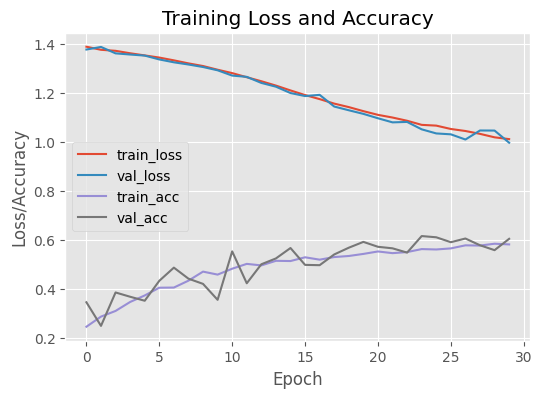

In [ ]:
plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, n_epochs, append_to_tile = "")

### Test Model

Test Loss: 1.053 |  Test Acc: 58.87% | Test F1: 31.33%



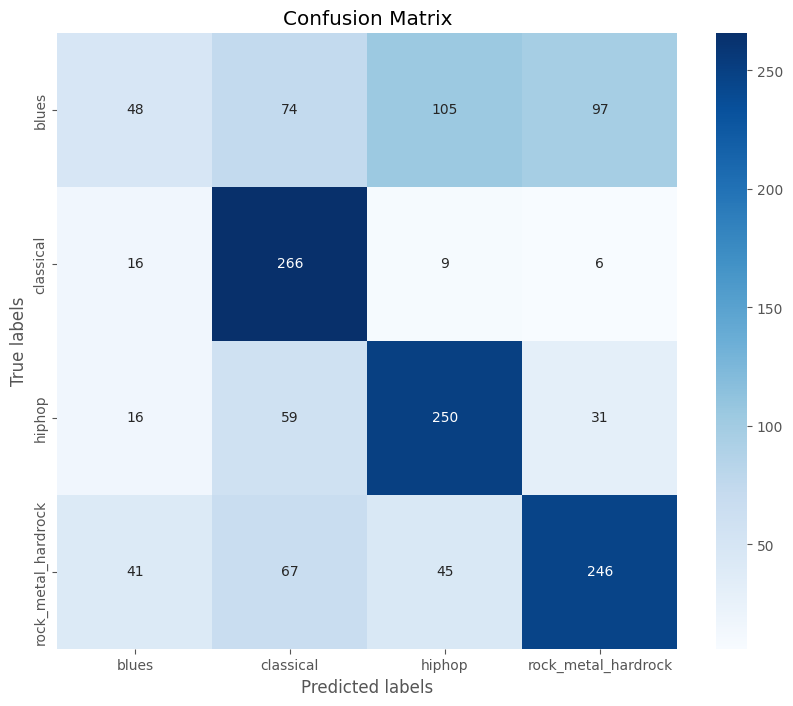

In [ ]:
test_loss, test_acc, test_f1, test_cf = evaluate(model, test_mfs_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1*100:.2f}%\n')
plot_confusion_matrix(test_cf, dist_labels)

### Use the model with the highest f1 score

Train the model for 30 epochs and save the model that achieved the best f1 score in validation dataset

In [ ]:
#train the model on the training dataloader
#evaluates the model on the validation dataloader
#returns the model that achieved the best f1 score
#in validation dataset and the max f1 score
def find_max_f1_model(model, epochs, optimizer, criterion, train_dataloader, validation_dataloader):
  max_f1_model = None
  max_f1 = 0

  for epoch in range(epochs):
    print(f'Epoch: {epoch+1:02}')
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1, valid_cf = evaluate(model, validation_dataloader, criterion)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. F1: {valid_f1*100:.2f}%')

    if valid_f1 > max_f1:
      max_f1 = valid_f1
      max_f1_model = model

  return max_f1_model, max_f1

In [ ]:
if torch.cuda.is_available():
  print('Gpu available!')
  device = 'cuda'

model = FullyConnectedNN(D_in, D_out)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

if device == 'cuda':
  max_f1_model, max_f1 = find_max_f1_model(
      model, n_epochs, optimizer, criterion, train_mfs_dataloader, val_mfs_dataloader
  )

  print(f'Max validation f1 achieved in {n_epochs}: {max_f1*100:.2f}%')

else:
  print('No available gpu...')

Gpu available!
Epoch: 01
	Train Loss: 1.392 | Train Acc: 26.41%
	 Val. Loss: 1.387 |  Val. Acc: 18.38% | Val. F1: 15.34%
Epoch: 02
	Train Loss: 1.380 | Train Acc: 30.09%
	 Val. Loss: 1.380 |  Val. Acc: 25.37% | Val. F1: 10.49%
Epoch: 03
	Train Loss: 1.372 | Train Acc: 34.84%
	 Val. Loss: 1.372 |  Val. Acc: 30.88% | Val. F1: 20.35%
Epoch: 04
	Train Loss: 1.364 | Train Acc: 34.72%
	 Val. Loss: 1.363 |  Val. Acc: 35.00% | Val. F1: 26.19%
Epoch: 05
	Train Loss: 1.356 | Train Acc: 38.78%
	 Val. Loss: 1.354 |  Val. Acc: 43.62% | Val. F1: 35.47%
Epoch: 06
	Train Loss: 1.345 | Train Acc: 39.41%
	 Val. Loss: 1.347 |  Val. Acc: 30.88% | Val. F1: 20.11%
Epoch: 07
	Train Loss: 1.335 | Train Acc: 40.44%
	 Val. Loss: 1.332 |  Val. Acc: 43.38% | Val. F1: 28.82%
Epoch: 08
	Train Loss: 1.321 | Train Acc: 41.03%
	 Val. Loss: 1.320 |  Val. Acc: 44.50% | Val. F1: 28.60%
Epoch: 09
	Train Loss: 1.311 | Train Acc: 42.09%
	 Val. Loss: 1.306 |  Val. Acc: 45.88% | Val. F1: 37.04%
Epoch: 10
	Train Loss: 1.294 | 

Test Loss: 1.023 |  Test Acc: 60.90% | Test F1: 28.96%



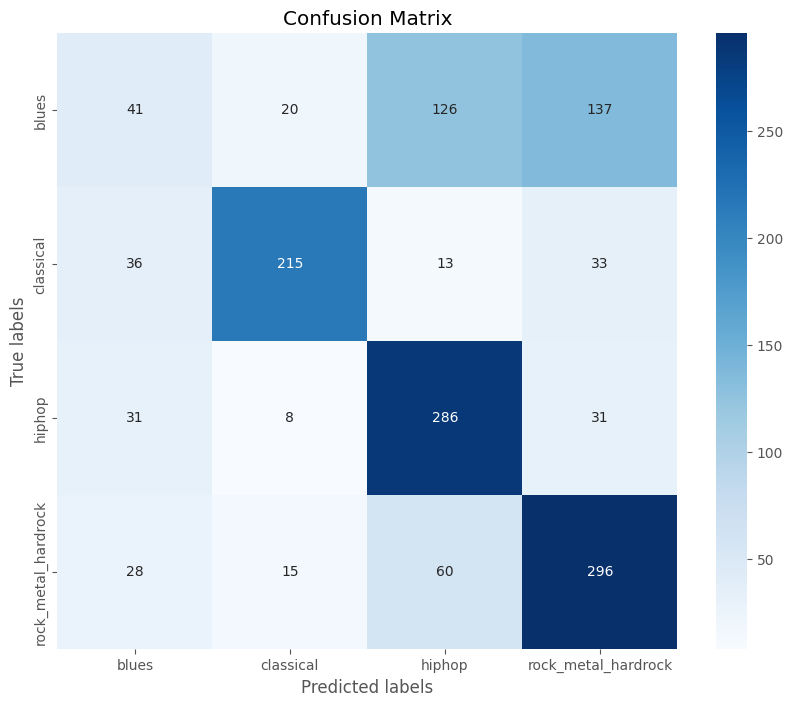

In [ ]:
test_loss, test_acc, test_f1, test_cf = evaluate(max_f1_model, test_mfs_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1*100:.2f}%\n')
plot_confusion_matrix(test_cf, dist_labels)

It seems that we succeed in our attempt to optimize the training of our model by stopping the training of the model when maximum validation f1 score was achieved. The scores of this model are slightly better that that of the previous.

## Ex. 2: Convolutional Neural Network

Use mel-spectograms as data

In [29]:
test_melgs_dataset = Dataset(test_melgs_x, test_y)
train_melgs_dataset = Dataset(train_melgs_x, train_y)
val_melgs_dataset = Dataset(val_melgs_x, val_y)

In [30]:
batch_size = 16
num_workers = 1  #for reproducability
test_melgs_dataloader = DataLoader(test_melgs_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
train_melgs_dataloader = DataLoader(train_melgs_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_melgs_dataloader = DataLoader(val_melgs_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [31]:
decoded_labels = label_encoder.inverse_transform(test_y)
rand_melgs = []
rand_melgs_labels = []
for i in range(4): #4 classes totally
  rand_idx = np.where(test_y == i)[0][0]
  rand_melg = test_melgs_x[rand_idx]
  rand_melg_label = decoded_labels[rand_idx]
  rand_melgs.append(rand_melg)
  rand_melgs_labels.append(rand_melg_label)

Plot random melgrams

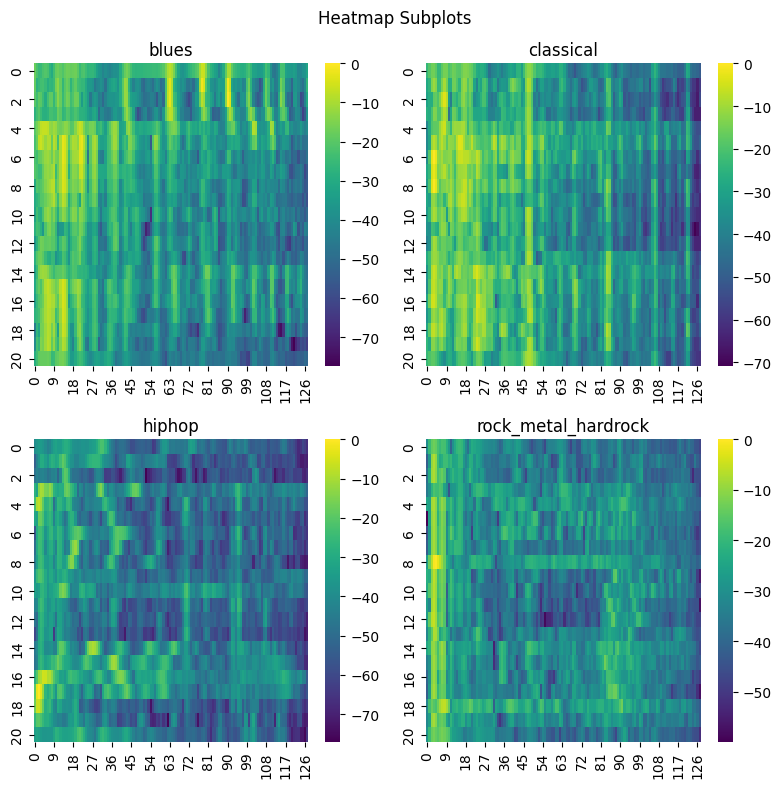

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
for i in range(len(rand_melgs)):
    rand_melg = rand_melgs[i]
    rand_melg_label = rand_melgs_labels[i]
    ax = axes[i]
    sns.heatmap(rand_melg, cmap='viridis', ax=ax)
    ax.set_title(rand_melg_label.format(i+1))

plt.suptitle('Heatmap Subplots')
plt.tight_layout()
plt.show()

### CNN Model

In [15]:
set_seeds(seed)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Reproducability
if device.type == "cuda":
    torch.cuda.manual_seed(seed)

Convolutional Neural Network consisting of
* A sequence of four convolutional layers, with kernel size 5, with the following channel sequence 1, 16, 32, 64, 64, 128
* The output of the last convolutional level is input to a fully convolutional connected neural network of 5 levels with number of neurons: x
(convolutional network output dimension), 1024, 256, 32, out_dim

In [17]:
class CNN(nn.Module):
    def __init__(self, out_dim):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(),
        )

        conv_output_size = self._get_conv_output_size((1, 21, 128))

        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, out_dim)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def _get_conv_output_size(self, input_shape):
        input_tensor = torch.zeros(1, *input_shape)
        output_tensor = self.conv_layers(input_tensor)
        conv_output_size = output_tensor.view(1, -1).size(1)
        return conv_output_size

### Train - Evaluate

In [18]:
def get_f1(y_true, y_pred):
    y_pred = y_pred.argmax(dim=1).cpu().numpy()
    y_true = y_true.cpu().numpy()
    f1_weighted = f1_score(y_true, y_pred, average='macro')
    return f1_weighted

In [19]:
#train the model on the training dataloader (for 1 epoch)
#returns average loss and average accuracy
def train_CNN(model, dataloader, optimizer, criterion, scheduler=None):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for X, y in dataloader:
        X = X.unsqueeze(1)
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        pred = model(X)
        loss = criterion(pred, y)
        acc = get_accuracy(y, pred)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    if scheduler is not None:
        scheduler.step()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [20]:
#evaluates the model on the validation dataset (for 1 epoch)
#returns average loss, average accuracy, average f1 score
def evaluate_CNN(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0

    model.eval()
    with torch.no_grad():
      for X, y in dataloader:
          X = X.unsqueeze(1)
          X = X.to(device)
          y = y.to(device)
          pred = model(X.float())

          loss = criterion(pred, y)
          acc = get_accuracy(y, pred)
          f1 = get_f1(y, pred)

          epoch_loss += loss.item()
          epoch_acc += acc.item()
          epoch_f1 += f1.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader), epoch_f1 / len(dataloader)

In [21]:
#train the model on the training dataloader
#evaluates the model on the validation dataloader
#returns lists of train loss and accuracy and valid loss, accuracy and f1 score
def train_eval_CNN(model, epochs, optimizer, criterion, train_dataloader, validation_dataloader, classes=[], print_res=True, scheduler=None):
  train_loss_list = []
  train_acc_list = []
  valid_loss_list = []
  valid_acc_list = []
  valid_f1_list = []

  for epoch in range(epochs):
    if print_res:
      print(f'Epoch: {epoch+1:02}')

    train_loss, train_acc = train_CNN(model, train_dataloader, optimizer, criterion,scheduler)
    valid_loss, valid_acc, valid_f1 = evaluate_CNN(model, validation_dataloader, criterion)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    valid_f1_list.append(valid_f1)

    if print_res:
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. F1: {valid_f1*100:.2f}%')

  return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list

Train - Evaluate CNN Model without pooling and padding

In [22]:
CNN_out_dim = 4
set_seeds(seed)
CNN_model = CNN(CNN_out_dim)
CNN_model.to(device)
CNN_criterion = nn.CrossEntropyLoss()
CNN_lr=0.00001
CNN_optimizer = optim.Adam(CNN_model.parameters(), lr=CNN_lr)
CNN_n_epochs = 4

In [ ]:
start_time = time.time()
train_loss_list_CNN, train_acc_list_CNN, valid_loss_list_CNN, valid_acc_list_CNN, valid_f1_list_CNN = train_eval_CNN(
      CNN_model, CNN_n_epochs, CNN_optimizer, CNN_criterion, train_melgs_dataloader, val_melgs_dataloader
  )
end_time = time.time()
total_time = end_time-start_time
total_time = "{:.3f}".format(total_time)

print(f'Total execution time for CNN without pooling and padding: {total_time} seconds')

Epoch: 01
	Train Loss: 1.300 | Train Acc: 35.97%
	 Val. Loss: 1.151 |  Val. Acc: 42.50% | Val. F1: 26.89%
Epoch: 02
	Train Loss: 1.089 | Train Acc: 48.81%
	 Val. Loss: 1.043 |  Val. Acc: 53.12% | Val. F1: 47.89%
Epoch: 03
	Train Loss: 0.935 | Train Acc: 59.34%
	 Val. Loss: 0.909 |  Val. Acc: 62.62% | Val. F1: 59.59%
Epoch: 04
	Train Loss: 0.841 | Train Acc: 64.94%
	 Val. Loss: 0.861 |  Val. Acc: 64.00% | Val. F1: 61.32%
Total execution time for CNN without pooling and padding: 60.542 seconds


Training proccess without pooling and padding seem to be slow and the model seem to be complex.

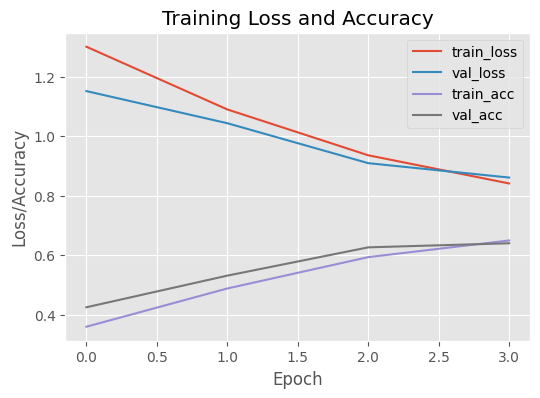

In [ ]:
plot_loss_acc(train_loss_list_CNN, valid_loss_list_CNN, train_acc_list_CNN, valid_acc_list_CNN, CNN_n_epochs, append_to_tile = "")

### Test Model

In [ ]:
test_loss, test_acc, test_f1 = evaluate_CNN(CNN_model, test_melgs_dataloader, CNN_criterion)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1*100:.2f}%\n')

Test Loss: 0.908 |  Test Acc: 62.43% | Test F1: 33.60%



### CNN Model With Pooling and Padding

In [53]:
class CNN_pool_pad(nn.Module):
    def __init__(self, out_dim, activation, dropout_rate=0):
        super(CNN_pool_pad, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            activation(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            activation(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            activation(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            activation(),
            nn.MaxPool2d(kernel_size=2)
        )

        conv_output_size = self._get_conv_output_size((1, 21, 128))

        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 1024),
            activation(),
            nn.Linear(1024, 256),
            activation(),
            nn.Linear(256, 32),
            activation(),
            nn.Linear(32, out_dim)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def _get_conv_output_size(self, input_shape):
        input_tensor = torch.zeros(1, *input_shape)
        output_tensor = self.conv_layers(input_tensor)
        conv_output_size = output_tensor.view(1, -1).size(1)
        return conv_output_size

In [24]:
CNN_pool_pad_out_dim = 4
set_seeds(seed)
CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,nn.ReLU)
CNN_pool_pad_model.to(device)
CNN_pool_pad_criterion = nn.CrossEntropyLoss()
CNN_pool_pad_lr=0.00001
CNN_pool_pad_optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=CNN_pool_pad_lr)
CNN_pool_pad_n_epochs = 5

In [ ]:
start_time = time.time()
train_loss_list_CNN_pool_pad, train_acc_list_CNN_pool_pad, valid_loss_list_CNN_pool_pad, valid_acc_list_CNN_pool_pad, valid_f1_list_CNN_pool_pad = train_eval_CNN(
      CNN_pool_pad_model, CNN_pool_pad_n_epochs, CNN_pool_pad_optimizer, CNN_pool_pad_criterion, train_melgs_dataloader, val_melgs_dataloader
  )
end_time = time.time()
total_time = end_time-start_time
total_time = "{:.3f}".format(total_time)

print(f'Total execution time for CNN with pooling and padding:: {total_time} seconds')

Epoch: 01
	Train Loss: 1.370 | Train Acc: 30.91%
	 Val. Loss: 1.362 |  Val. Acc: 26.38% | Val. F1: 12.53%
Epoch: 02
	Train Loss: 1.305 | Train Acc: 41.88%
	 Val. Loss: 1.268 |  Val. Acc: 42.25% | Val. F1: 30.46%
Epoch: 03
	Train Loss: 1.176 | Train Acc: 46.56%
	 Val. Loss: 1.120 |  Val. Acc: 53.87% | Val. F1: 44.59%
Epoch: 04
	Train Loss: 1.062 | Train Acc: 52.03%
	 Val. Loss: 1.043 |  Val. Acc: 51.75% | Val. F1: 45.07%
Epoch: 05
	Train Loss: 0.975 | Train Acc: 56.50%
	 Val. Loss: 0.954 |  Val. Acc: 61.88% | Val. F1: 58.72%
Total execution time for CNN with pooling and padding:: 7.937 seconds


With pooling and padding the training proccess is much faster

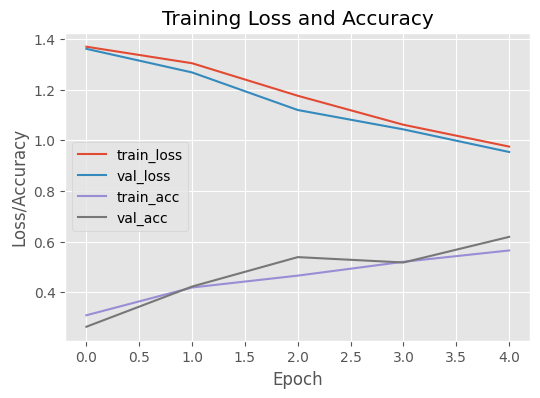

In [ ]:
plot_loss_acc(train_loss_list_CNN_pool_pad, valid_loss_list_CNN_pool_pad, train_acc_list_CNN_pool_pad, valid_acc_list_CNN_pool_pad, CNN_pool_pad_n_epochs, append_to_tile = "")

The complexity of the model seem to decrease with the use of pooling and padding. These operations help the model capture relevant features and patterns, improve translation invariance, and maintain the spatial resolution of the input data.

### Test model with pooling and padding

In [ ]:
test_loss, test_acc, test_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1*100:.2f}%\n')

Test Loss: 0.983 |  Test Acc: 57.34% | Test F1: 30.06%



The scores with pooling and padding are worse

## Improving Performance

In [26]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.6 MB/s eta 0:00:00


In [27]:
import optuna

### Experiment with Optimizers

In [33]:
#SparseAdam does not support dense gradients
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax']
epoch_choices = [5, 10, 15, 20]
learning_rate_choices = [0.00001, 0.0001, 0.001, 0.01]

results = []

for optimizer_name in optimizers:
    def objective(trial):
        epoch = trial.suggest_categorical('epoch', epoch_choices)
        learning_rate = trial.suggest_categorical('learning_rate', learning_rate_choices)
        set_seeds(seed)
        CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,nn.ReLU)
        CNN_pool_pad_model.to(device)

        optimizer = getattr(optim, optimizer_name)(CNN_pool_pad_model.parameters(), lr=learning_rate)
        train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list = train_eval_CNN(
            CNN_pool_pad_model, epoch, optimizer, CNN_pool_pad_criterion, train_melgs_dataloader, val_melgs_dataloader, [], False, None)


        #_, _, valid_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)

        return valid_f1_list[-1]

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)

    # Access the best hyperparameters and evaluation score
    best_params = study.best_params

    #train the model with best hyperparamters and the current optimizer
    set_seeds(seed)
    CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,nn.ReLU)
    CNN_pool_pad_model.to(device)
    optimizer = getattr(optim, optimizer_name)(CNN_pool_pad_model.parameters(), lr=best_params['learning_rate'])
    for i in range(best_params['epoch']):
      train_CNN(CNN_pool_pad_model, train_melgs_dataloader, optimizer, CNN_pool_pad_criterion)

    #get accuracy, f1 score on test dataset
    test_loss, test_acc, test_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)
    test_acc = "{:.2f}".format(test_acc*100) + '%'
    test_f1 = "{:.2f}".format(test_f1*100) + '%'
    results.append([optimizer_name, test_acc, test_f1, best_params['epoch'], best_params['learning_rate']])

[I 2023-07-06 15:10:47,710] A new study created in memory with name: no-name-4ed41012-0a45-46b4-96dd-6641f1a5e8ac
[I 2023-07-06 15:11:11,254] Trial 0 finished with value: 0.2737462929227635 and parameters: {'epoch': 10, 'learning_rate': 0.001}. Best is trial 0 with value: 0.2737462929227635.
[I 2023-07-06 15:11:20,159] Trial 1 finished with value: 0.18339978734715573 and parameters: {'epoch': 5, 'learning_rate': 0.001}. Best is trial 0 with value: 0.2737462929227635.
[I 2023-07-06 15:11:38,189] Trial 2 finished with value: 0.5983475274725274 and parameters: {'epoch': 10, 'learning_rate': 0.01}. Best is trial 2 with value: 0.5983475274725274.
[I 2023-07-06 15:11:48,959] Trial 3 finished with value: 0.22970697113344166 and parameters: {'epoch': 5, 'learning_rate': 0.001}. Best is trial 2 with value: 0.5983475274725274.
[I 2023-07-06 15:12:22,502] Trial 4 finished with value: 0.5341110115374821 and parameters: {'epoch': 15, 'learning_rate': 0.01}. Best is trial 2 with value: 0.59834752747

In [34]:
headers = ["Optimizer", "Test Accuracy", "Test F1 Score", "Best Epochs", "Best Learning Rate"]
print(tabulate(results, headers, tablefmt="grid"))

+-------------+-----------------+-----------------+---------------+----------------------+
| Optimizer   | Test Accuracy   | Test F1 Score   |   Best Epochs |   Best Learning Rate |
+=============+=================+=================+===============+======================+
| Adadelta    | 59.08%          | 33.15%          |            10 |               0.01   |
+-------------+-----------------+-----------------+---------------+----------------------+
| Adagrad     | 70.71%          | 37.02%          |            15 |               0.01   |
+-------------+-----------------+-----------------+---------------+----------------------+
| Adam        | 74.06%          | 37.81%          |            20 |               0.0001 |
+-------------+-----------------+-----------------+---------------+----------------------+
| AdamW       | 68.75%          | 36.83%          |             5 |               0.0001 |
+-------------+-----------------+-----------------+---------------+----------------------+

From the given results, it appears that Adam generally outperforms the other optimizers in terms of both accuracy and F1 score. Adagrad and Adamax show relatively similar performance but are slightly behind Adam. AdamW and Adadelta exhibit lower accuracy and F1 scores compared to the other activation functions.

### Experiment with Activation Functions

In [35]:
activation_functions = ['Hardshrink', 'Hardswish', 'LeakyReLU', 'PReLU', 'ReLU']
epoch_choices = [5, 10, 15, 20]
learning_rate_choices = [0.00001, 0.0001, 0.001, 0.01]

results = []

for activation_str in activation_functions:
    def objective(trial):
        epoch = trial.suggest_categorical('epoch', epoch_choices)
        learning_rate = trial.suggest_categorical('learning_rate', learning_rate_choices)

        activation_function = eval('nn.' + activation_str)
        set_seeds(seed)
        CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,activation_function)
        CNN_pool_pad_model.to(device)

        optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=learning_rate)
        train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list = train_eval_CNN(
            CNN_pool_pad_model, epoch, optimizer, CNN_pool_pad_criterion, train_melgs_dataloader, val_melgs_dataloader, [], False, None)


        #_, _, valid_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)

        return valid_f1_list[-1]

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)

    # Access the best hyperparameters and evaluation score
    best_params = study.best_params

    #train the model with best hyperparamters and the current optimizer
    activation_function = eval('nn.' + activation_str)
    set_seeds(seed)
    CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,activation_function)
    CNN_pool_pad_model.to(device)
    optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=best_params['learning_rate'])
    for i in range(best_params['epoch']):
      train_CNN(CNN_pool_pad_model, train_melgs_dataloader, optimizer, CNN_pool_pad_criterion)

    #get accuracy, f1 score on test dataset
    test_loss, test_acc, test_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)
    test_acc = "{:.2f}".format(test_acc*100) + '%'
    test_f1 = "{:.2f}".format(test_f1*100) + '%'
    results.append([activation_str, test_acc, test_f1, best_params['epoch'], best_params['learning_rate']])

[I 2023-07-06 15:29:25,644] A new study created in memory with name: no-name-4d35ba38-8f88-4019-a3f9-636763fc613f
[I 2023-07-06 15:29:49,004] Trial 0 finished with value: 0.6176670437405732 and parameters: {'epoch': 15, 'learning_rate': 1e-05}. Best is trial 0 with value: 0.6176670437405732.
[I 2023-07-06 15:29:57,040] Trial 1 finished with value: 0.5407144849904137 and parameters: {'epoch': 5, 'learning_rate': 0.001}. Best is trial 0 with value: 0.6176670437405732.
[I 2023-07-06 15:30:12,404] Trial 2 finished with value: 0.5873393718854244 and parameters: {'epoch': 10, 'learning_rate': 1e-05}. Best is trial 0 with value: 0.6176670437405732.
[I 2023-07-06 15:30:27,624] Trial 3 finished with value: 0.7105222555222557 and parameters: {'epoch': 10, 'learning_rate': 0.0001}. Best is trial 3 with value: 0.7105222555222557.
[I 2023-07-06 15:30:50,952] Trial 4 finished with value: 0.651291792357969 and parameters: {'epoch': 15, 'learning_rate': 1e-05}. Best is trial 3 with value: 0.7105222555

In [36]:
headers = ["Activation ", "Test Accuracy", "Test F1 Score", "Best Epochs", "Best Learning Rate"]
print(tabulate(results, headers, tablefmt="grid"))

+---------------+-----------------+-----------------+---------------+----------------------+
| Activation    | Test Accuracy   | Test F1 Score   |   Best Epochs |   Best Learning Rate |
+===============+=================+=================+===============+======================+
| Hardshrink    | 71.58%          | 38.52%          |            10 |               0.0001 |
+---------------+-----------------+-----------------+---------------+----------------------+
| Hardswish     | 70.28%          | 46.26%          |             5 |               0.0001 |
+---------------+-----------------+-----------------+---------------+----------------------+
| LeakyReLU     | 71.29%          | 38.07%          |            15 |               0.0001 |
+---------------+-----------------+-----------------+---------------+----------------------+
| PReLU         | 72.17%          | 39.72%          |            20 |               0.0001 |
+---------------+-----------------+-----------------+---------------+-

Among the activation functions tested, PReLU performs the best in terms of accuracy, while Hardswish achieves the highest F1 score. Hardshrink and LeakyReLU show similar accuracy and F1 scores, while ReLU has lower accuracy but a relatively higher F1 score.

### Experiment with learning rate schedulers

In [42]:
schedulers = [
  'None',
  'lr_scheduler.CosineAnnealingLR',
  'lr_scheduler.OneCycleLR',
]

epoch_choices = [5, 10, 15, 20]
learning_rate_choices = [0.00001, 0.0001, 0.001, 0.01]
max_lr_values = [0.01, 0.1, 0.001, 0.0001]

results = []

for scheduler_str in schedulers:
    def objective(trial):
        epoch = trial.suggest_categorical('epoch', epoch_choices)
        learning_rate = trial.suggest_categorical('learning_rate', learning_rate_choices)
        if scheduler_str == 'lr_scheduler.OneCycleLR':
            max_lr = trial.suggest_categorical('max_lr', max_lr_values)

        set_seeds(seed)
        CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim, nn.Hardswish)
        CNN_pool_pad_model.to(device)


        optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=learning_rate)
        scheduler = None
        if scheduler_str == 'lr_scheduler.CosineAnnealingLR':
          scheduler = eval(scheduler_str)
          scheduler = scheduler(optimizer, verbose=True, T_max = epoch)
        elif scheduler_str == 'lr_scheduler.OneCycleLR':
          scheduler = eval(scheduler_str)
          scheduler = scheduler(optimizer, verbose=True, max_lr = max_lr,total_steps =epoch*len(train_melgs_dataloader))

        if scheduler_str == 'None':
            train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list = train_eval_CNN(
              CNN_pool_pad_model, epoch, optimizer, CNN_pool_pad_criterion, train_melgs_dataloader, val_melgs_dataloader,[],False, None)
        else:
            train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list = train_eval_CNN(
              CNN_pool_pad_model, epoch, optimizer, CNN_pool_pad_criterion, train_melgs_dataloader, val_melgs_dataloader, [], False, scheduler)


        return valid_f1_list[-1]

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=8)

    # Access the best hyperparameters and evaluation score
    best_params = study.best_params

    #train the model with best hyperparamters and the current optimizer
    set_seeds(seed)
    CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,nn.Hardswish)
    CNN_pool_pad_model.to(device)
    optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=best_params['learning_rate'])
    if scheduler_str == 'lr_scheduler.CosineAnnealingLR':
          scheduler = eval(scheduler_str)
          scheduler = scheduler(optimizer, verbose=True, T_max = best_params['epoch'])
    elif scheduler_str == 'lr_scheduler.OneCycleLR':
          scheduler = eval(scheduler_str)
          scheduler = scheduler(optimizer, verbose=True, max_lr = best_params['max_lr'], total_steps=best_params['epoch']*len(train_melgs_dataloader) )

    if scheduler_str == 'None':
        for i in range(best_params['epoch']):
          train_CNN(CNN_pool_pad_model, train_melgs_dataloader, optimizer, CNN_pool_pad_criterion)
    else:
        for i in range(best_params['epoch']):
          train_CNN(CNN_pool_pad_model, train_melgs_dataloader, optimizer, CNN_pool_pad_criterion, scheduler)

    #get accuracy, f1 score on test dataset
    test_loss, test_acc, test_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)
    test_acc = "{:.2f}".format(test_acc*100) + '%'
    test_f1 = "{:.2f}".format(test_f1*100) + '%'
    results.append([scheduler_str, test_acc, test_f1, best_params['epoch'], best_params['learning_rate']])

[I 2023-07-06 16:06:46,073] A new study created in memory with name: no-name-813ec838-8c36-48c0-a6ba-b72757895f56
[I 2023-07-06 16:07:02,418] Trial 0 finished with value: 0.7632740461293095 and parameters: {'epoch': 10, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.7632740461293095.
[I 2023-07-06 16:07:13,171] Trial 1 finished with value: 0.6893202957173543 and parameters: {'epoch': 5, 'learning_rate': 1e-05}. Best is trial 0 with value: 0.7632740461293095.
[I 2023-07-06 16:07:45,308] Trial 2 finished with value: 0.7362728660228659 and parameters: {'epoch': 20, 'learning_rate': 1e-05}. Best is trial 0 with value: 0.7632740461293095.
[I 2023-07-06 16:08:01,570] Trial 3 finished with value: 0.09886322370290598 and parameters: {'epoch': 10, 'learning_rate': 0.01}. Best is trial 0 with value: 0.7632740461293095.
[I 2023-07-06 16:08:10,045] Trial 4 finished with value: 0.7144517261061378 and parameters: {'epoch': 5, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.763274046

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.9384e-03.
Adjusting learning rate of group 0 to 9.7553e-03.
Adjusting learning rate of group 0 to 9.4550e-03.
Adjusting learning rate of group 0 to 9.0451e-03.
Adjusting learning rate of group 0 to 8.5355e-03.
Adjusting learning rate of group 0 to 7.9389e-03.
Adjusting learning rate of group 0 to 7.2700e-03.
Adjusting learning rate of group 0 to 6.5451e-03.
Adjusting learning rate of group 0 to 5.7822e-03.
Adjusting learning rate of group 0 to 5.0000e-03.
Adjusting learning rate of group 0 to 4.2178e-03.
Adjusting learning rate of group 0 to 3.4549e-03.
Adjusting learning rate of group 0 to 2.7300e-03.
Adjusting learning rate of group 0 to 2.0611e-03.
Adjusting learning rate of group 0 to 1.4645e-03.
Adjusting learning rate of group 0 to 9.5492e-04.
Adjusting learning rate of group 0 to 5.4497e-04.
Adjusting learning rate of group 0 to 2.4472e-04.
Adjusting learning rate of group 0 to 6.1558e-05.


[I 2023-07-06 16:10:23,249] Trial 0 finished with value: 0.09822017338937508 and parameters: {'epoch': 20, 'learning_rate': 0.01}. Best is trial 0 with value: 0.09822017338937508.


Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 9.0451e-05.
Adjusting learning rate of group 0 to 6.5451e-05.
Adjusting learning rate of group 0 to 3.4549e-05.
Adjusting learning rate of group 0 to 9.5492e-06.
Adjusting learning rate of group 0 to 0.0000e+00.


[I 2023-07-06 16:10:33,751] Trial 1 finished with value: 0.7638990037740038 and parameters: {'epoch': 5, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.7638990037740038.


Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 9.8907e-05.
Adjusting learning rate of group 0 to 9.5677e-05.
Adjusting learning rate of group 0 to 9.0451e-05.
Adjusting learning rate of group 0 to 8.3457e-05.
Adjusting learning rate of group 0 to 7.5000e-05.
Adjusting learning rate of group 0 to 6.5451e-05.
Adjusting learning rate of group 0 to 5.5226e-05.
Adjusting learning rate of group 0 to 4.4774e-05.
Adjusting learning rate of group 0 to 3.4549e-05.
Adjusting learning rate of group 0 to 2.5000e-05.
Adjusting learning rate of group 0 to 1.6543e-05.
Adjusting learning rate of group 0 to 9.5492e-06.
Adjusting learning rate of group 0 to 4.3227e-06.
Adjusting learning rate of group 0 to 1.0926e-06.
Adjusting learning rate of group 0 to 0.0000e+00.


[I 2023-07-06 16:10:58,404] Trial 2 finished with value: 0.763780146052205 and parameters: {'epoch': 15, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.7638990037740038.


Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 9.9384e-05.
Adjusting learning rate of group 0 to 9.7553e-05.
Adjusting learning rate of group 0 to 9.4550e-05.
Adjusting learning rate of group 0 to 9.0451e-05.
Adjusting learning rate of group 0 to 8.5355e-05.
Adjusting learning rate of group 0 to 7.9389e-05.
Adjusting learning rate of group 0 to 7.2700e-05.
Adjusting learning rate of group 0 to 6.5451e-05.
Adjusting learning rate of group 0 to 5.7822e-05.
Adjusting learning rate of group 0 to 5.0000e-05.
Adjusting learning rate of group 0 to 4.2178e-05.
Adjusting learning rate of group 0 to 3.4549e-05.
Adjusting learning rate of group 0 to 2.7300e-05.
Adjusting learning rate of group 0 to 2.0611e-05.
Adjusting learning rate of group 0 to 1.4645e-05.
Adjusting learning rate of group 0 to 9.5492e-06.
Adjusting learning rate of group 0 to 5.4497e-06.
Adjusting learning rate of group 0 to 2.4472e-06.
Adjusting learning rate of group 0 to 6.1558e-07.


[I 2023-07-06 16:11:31,262] Trial 3 finished with value: 0.7409287109948873 and parameters: {'epoch': 20, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.7638990037740038.


Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 9.0451e-06.
Adjusting learning rate of group 0 to 6.5451e-06.
Adjusting learning rate of group 0 to 3.4549e-06.
Adjusting learning rate of group 0 to 9.5492e-07.
Adjusting learning rate of group 0 to 0.0000e+00.


[I 2023-07-06 16:11:40,509] Trial 4 finished with value: 0.679382437007437 and parameters: {'epoch': 5, 'learning_rate': 1e-05}. Best is trial 1 with value: 0.7638990037740038.


Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 9.0451e-06.
Adjusting learning rate of group 0 to 6.5451e-06.
Adjusting learning rate of group 0 to 3.4549e-06.
Adjusting learning rate of group 0 to 9.5492e-07.
Adjusting learning rate of group 0 to 0.0000e+00.


[I 2023-07-06 16:11:49,145] Trial 5 finished with value: 0.5965803885656825 and parameters: {'epoch': 5, 'learning_rate': 1e-05}. Best is trial 1 with value: 0.7638990037740038.


Adjusting learning rate of group 0 to 1.0000e-05.
Adjusting learning rate of group 0 to 9.7553e-06.
Adjusting learning rate of group 0 to 9.0451e-06.
Adjusting learning rate of group 0 to 7.9389e-06.
Adjusting learning rate of group 0 to 6.5451e-06.
Adjusting learning rate of group 0 to 5.0000e-06.
Adjusting learning rate of group 0 to 3.4549e-06.
Adjusting learning rate of group 0 to 2.0611e-06.
Adjusting learning rate of group 0 to 9.5492e-07.
Adjusting learning rate of group 0 to 2.4472e-07.
Adjusting learning rate of group 0 to 0.0000e+00.


[I 2023-07-06 16:12:05,355] Trial 6 finished with value: 0.6697775280275278 and parameters: {'epoch': 10, 'learning_rate': 1e-05}. Best is trial 1 with value: 0.7638990037740038.


Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.0451e-04.
Adjusting learning rate of group 0 to 6.5451e-04.
Adjusting learning rate of group 0 to 3.4549e-04.
Adjusting learning rate of group 0 to 9.5492e-05.
Adjusting learning rate of group 0 to 0.0000e+00.


[I 2023-07-06 16:12:17,763] Trial 7 finished with value: 0.7216418213279668 and parameters: {'epoch': 5, 'learning_rate': 0.001}. Best is trial 1 with value: 0.7638990037740038.


Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 9.0451e-05.
Adjusting learning rate of group 0 to 6.5451e-05.
Adjusting learning rate of group 0 to 3.4549e-05.
Adjusting learning rate of group 0 to 9.5492e-06.
Adjusting learning rate of group 0 to 0.0000e+00.


[I 2023-07-06 16:12:24,576] A new study created in memory with name: no-name-0f622502-10db-4d1e-9bcf-9da7ea051bd8


Adjusting learning rate of group 0 to 4.0000e-06.
Adjusting learning rate of group 0 to 4.0026e-06.
Adjusting learning rate of group 0 to 4.0106e-06.
Adjusting learning rate of group 0 to 4.0238e-06.
Adjusting learning rate of group 0 to 4.0424e-06.
Adjusting learning rate of group 0 to 4.0662e-06.


[I 2023-07-06 16:12:33,199] Trial 0 finished with value: 0.6109549434483647 and parameters: {'epoch': 5, 'learning_rate': 0.01, 'max_lr': 0.0001}. Best is trial 0 with value: 0.6109549434483647.


Adjusting learning rate of group 0 to 4.0000e-05.
Adjusting learning rate of group 0 to 4.0002e-05.
Adjusting learning rate of group 0 to 4.0007e-05.
Adjusting learning rate of group 0 to 4.0015e-05.
Adjusting learning rate of group 0 to 4.0026e-05.
Adjusting learning rate of group 0 to 4.0041e-05.
Adjusting learning rate of group 0 to 4.0059e-05.
Adjusting learning rate of group 0 to 4.0081e-05.
Adjusting learning rate of group 0 to 4.0105e-05.
Adjusting learning rate of group 0 to 4.0133e-05.
Adjusting learning rate of group 0 to 4.0165e-05.
Adjusting learning rate of group 0 to 4.0199e-05.
Adjusting learning rate of group 0 to 4.0237e-05.
Adjusting learning rate of group 0 to 4.0278e-05.
Adjusting learning rate of group 0 to 4.0323e-05.
Adjusting learning rate of group 0 to 4.0371e-05.
Adjusting learning rate of group 0 to 4.0422e-05.
Adjusting learning rate of group 0 to 4.0476e-05.
Adjusting learning rate of group 0 to 4.0534e-05.
Adjusting learning rate of group 0 to 4.0595e-05.


[I 2023-07-06 16:13:11,149] Trial 1 finished with value: 0.7744827737621854 and parameters: {'epoch': 20, 'learning_rate': 0.001, 'max_lr': 0.001}. Best is trial 1 with value: 0.7744827737621854.


Adjusting learning rate of group 0 to 4.0000e-05.
Adjusting learning rate of group 0 to 4.0007e-05.
Adjusting learning rate of group 0 to 4.0026e-05.
Adjusting learning rate of group 0 to 4.0059e-05.
Adjusting learning rate of group 0 to 4.0106e-05.
Adjusting learning rate of group 0 to 4.0165e-05.
Adjusting learning rate of group 0 to 4.0238e-05.
Adjusting learning rate of group 0 to 4.0323e-05.
Adjusting learning rate of group 0 to 4.0422e-05.
Adjusting learning rate of group 0 to 4.0535e-05.
Adjusting learning rate of group 0 to 4.0660e-05.


[I 2023-07-06 16:13:28,054] Trial 2 finished with value: 0.7533656204906207 and parameters: {'epoch': 10, 'learning_rate': 0.0001, 'max_lr': 0.001}. Best is trial 1 with value: 0.7744827737621854.


Adjusting learning rate of group 0 to 4.0000e-03.
Adjusting learning rate of group 0 to 4.0003e-03.
Adjusting learning rate of group 0 to 4.0012e-03.
Adjusting learning rate of group 0 to 4.0026e-03.
Adjusting learning rate of group 0 to 4.0047e-03.
Adjusting learning rate of group 0 to 4.0073e-03.
Adjusting learning rate of group 0 to 4.0106e-03.
Adjusting learning rate of group 0 to 4.0144e-03.
Adjusting learning rate of group 0 to 4.0188e-03.
Adjusting learning rate of group 0 to 4.0237e-03.
Adjusting learning rate of group 0 to 4.0293e-03.
Adjusting learning rate of group 0 to 4.0355e-03.
Adjusting learning rate of group 0 to 4.0422e-03.
Adjusting learning rate of group 0 to 4.0495e-03.
Adjusting learning rate of group 0 to 4.0574e-03.
Adjusting learning rate of group 0 to 4.0659e-03.


[I 2023-07-06 16:13:54,290] Trial 3 finished with value: 0.10148588630376214 and parameters: {'epoch': 15, 'learning_rate': 1e-05, 'max_lr': 0.1}. Best is trial 1 with value: 0.7744827737621854.


Adjusting learning rate of group 0 to 4.0000e-04.
Adjusting learning rate of group 0 to 4.0007e-04.
Adjusting learning rate of group 0 to 4.0026e-04.
Adjusting learning rate of group 0 to 4.0059e-04.
Adjusting learning rate of group 0 to 4.0106e-04.
Adjusting learning rate of group 0 to 4.0165e-04.
Adjusting learning rate of group 0 to 4.0238e-04.
Adjusting learning rate of group 0 to 4.0323e-04.
Adjusting learning rate of group 0 to 4.0422e-04.
Adjusting learning rate of group 0 to 4.0535e-04.
Adjusting learning rate of group 0 to 4.0660e-04.


[I 2023-07-06 16:14:16,897] Trial 4 finished with value: 0.7411770500741091 and parameters: {'epoch': 10, 'learning_rate': 0.001, 'max_lr': 0.01}. Best is trial 1 with value: 0.7744827737621854.


Adjusting learning rate of group 0 to 4.0000e-06.
Adjusting learning rate of group 0 to 4.0026e-06.
Adjusting learning rate of group 0 to 4.0106e-06.
Adjusting learning rate of group 0 to 4.0238e-06.
Adjusting learning rate of group 0 to 4.0424e-06.
Adjusting learning rate of group 0 to 4.0662e-06.


[I 2023-07-06 16:14:25,522] Trial 5 finished with value: 0.5481214063714064 and parameters: {'epoch': 5, 'learning_rate': 0.001, 'max_lr': 0.0001}. Best is trial 1 with value: 0.7744827737621854.


Adjusting learning rate of group 0 to 4.0000e-04.
Adjusting learning rate of group 0 to 4.0002e-04.
Adjusting learning rate of group 0 to 4.0007e-04.
Adjusting learning rate of group 0 to 4.0015e-04.
Adjusting learning rate of group 0 to 4.0026e-04.
Adjusting learning rate of group 0 to 4.0041e-04.
Adjusting learning rate of group 0 to 4.0059e-04.
Adjusting learning rate of group 0 to 4.0081e-04.
Adjusting learning rate of group 0 to 4.0105e-04.
Adjusting learning rate of group 0 to 4.0133e-04.
Adjusting learning rate of group 0 to 4.0165e-04.
Adjusting learning rate of group 0 to 4.0199e-04.
Adjusting learning rate of group 0 to 4.0237e-04.
Adjusting learning rate of group 0 to 4.0278e-04.
Adjusting learning rate of group 0 to 4.0323e-04.
Adjusting learning rate of group 0 to 4.0371e-04.
Adjusting learning rate of group 0 to 4.0422e-04.
Adjusting learning rate of group 0 to 4.0476e-04.
Adjusting learning rate of group 0 to 4.0534e-04.
Adjusting learning rate of group 0 to 4.0595e-04.


[I 2023-07-06 16:14:58,610] Trial 6 finished with value: 0.7181033419195181 and parameters: {'epoch': 20, 'learning_rate': 0.01, 'max_lr': 0.01}. Best is trial 1 with value: 0.7744827737621854.


Adjusting learning rate of group 0 to 4.0000e-05.
Adjusting learning rate of group 0 to 4.0026e-05.
Adjusting learning rate of group 0 to 4.0106e-05.
Adjusting learning rate of group 0 to 4.0238e-05.
Adjusting learning rate of group 0 to 4.0424e-05.
Adjusting learning rate of group 0 to 4.0662e-05.


[I 2023-07-06 16:15:07,949] Trial 7 finished with value: 0.7336700301332654 and parameters: {'epoch': 5, 'learning_rate': 0.001, 'max_lr': 0.001}. Best is trial 1 with value: 0.7744827737621854.


Adjusting learning rate of group 0 to 4.0000e-05.
Adjusting learning rate of group 0 to 4.0002e-05.
Adjusting learning rate of group 0 to 4.0007e-05.
Adjusting learning rate of group 0 to 4.0015e-05.
Adjusting learning rate of group 0 to 4.0026e-05.
Adjusting learning rate of group 0 to 4.0041e-05.
Adjusting learning rate of group 0 to 4.0059e-05.
Adjusting learning rate of group 0 to 4.0081e-05.
Adjusting learning rate of group 0 to 4.0105e-05.
Adjusting learning rate of group 0 to 4.0133e-05.
Adjusting learning rate of group 0 to 4.0165e-05.
Adjusting learning rate of group 0 to 4.0199e-05.
Adjusting learning rate of group 0 to 4.0237e-05.
Adjusting learning rate of group 0 to 4.0278e-05.
Adjusting learning rate of group 0 to 4.0323e-05.
Adjusting learning rate of group 0 to 4.0371e-05.
Adjusting learning rate of group 0 to 4.0422e-05.
Adjusting learning rate of group 0 to 4.0476e-05.
Adjusting learning rate of group 0 to 4.0534e-05.
Adjusting learning rate of group 0 to 4.0595e-05.


In [43]:
headers = ["Scheduler ", "Test Accuracy", "Test F1 Score", "Best Epochs", "Best Learning Rate"]
print(tabulate(results, headers, tablefmt="grid"))

+--------------------------------+-----------------+-----------------+---------------+----------------------+
| Scheduler                      | Test Accuracy   | Test F1 Score   |   Best Epochs |   Best Learning Rate |
+================================+=================+=================+===============+======================+
| None                           | 70.93%          | 41.66%          |            15 |               0.0001 |
+--------------------------------+-----------------+-----------------+---------------+----------------------+
| lr_scheduler.CosineAnnealingLR | 71.88%          | 41.38%          |             5 |               0.0001 |
+--------------------------------+-----------------+-----------------+---------------+----------------------+
| lr_scheduler.OneCycleLR        | 75.87%          | 48.05%          |            20 |               0.001  |
+--------------------------------+-----------------+-----------------+---------------+----------------------+


Incorporating a learning rate scheduler, such as the OneCycleLR scheduler, can improve the model's accuracy and F1 score compared to using no scheduler or a simpler scheduler like CosineAnnealingLR

### Batch Normalization

In [45]:
class CNN_pool_pad_batch(nn.Module):
    def __init__(self, out_dim, activation):
        super(CNN_pool_pad_batch, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            activation(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            activation(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            activation(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            activation(),
            nn.MaxPool2d(kernel_size=2)
        )

        conv_output_size = self._get_conv_output_size((1, 21, 128))

        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 1024),
            nn.BatchNorm1d(1024),
            activation(),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            activation(),
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            activation(),
            nn.Linear(32, out_dim)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def _get_conv_output_size(self, input_shape):
        input_tensor = torch.zeros(1, *input_shape)
        output_tensor = self.conv_layers(input_tensor)
        conv_output_size = output_tensor.view(1, -1).size(1)
        return conv_output_size


In [51]:
CNN_out_dim = 4
set_seeds(seed)
CNN_pool_pad_batch_model = CNN_pool_pad_batch(CNN_out_dim,nn.ReLU)
CNN_pool_pad_batch_model.to(device)
CNN_criterion = nn.CrossEntropyLoss()
lr=0.00001
CNN_optimizer = optim.Adam(CNN_pool_pad_batch_model.parameters(), lr=lr)
epochs = 6

In [52]:
train_loss_list_CNN_pool_pad, train_acc_list_CNN_pool_pad, valid_loss_list_CNN_pool_pad, valid_acc_list_CNN_pool_pad, valid_f1_list_CNN_pool_pad = train_eval_CNN(
      CNN_pool_pad_batch_model, epochs, CNN_optimizer, CNN_criterion, train_melgs_dataloader, val_melgs_dataloader
  )

Epoch: 01
	Train Loss: 1.158 | Train Acc: 52.38%
	 Val. Loss: 0.998 |  Val. Acc: 64.25% | Val. F1: 61.49%
Epoch: 02
	Train Loss: 0.970 | Train Acc: 66.88%
	 Val. Loss: 0.920 |  Val. Acc: 73.25% | Val. F1: 70.88%
Epoch: 03
	Train Loss: 0.898 | Train Acc: 70.25%
	 Val. Loss: 0.866 |  Val. Acc: 75.38% | Val. F1: 70.29%
Epoch: 04
	Train Loss: 0.848 | Train Acc: 73.81%
	 Val. Loss: 0.845 |  Val. Acc: 75.50% | Val. F1: 72.06%
Epoch: 05
	Train Loss: 0.811 | Train Acc: 75.59%
	 Val. Loss: 0.826 |  Val. Acc: 76.25% | Val. F1: 72.81%
Epoch: 06
	Train Loss: 0.778 | Train Acc: 77.62%
	 Val. Loss: 0.801 |  Val. Acc: 76.62% | Val. F1: 71.79%


In [54]:
test_loss, test_acc, test_f1 = evaluate_CNN(CNN_pool_pad_batch_model, test_melgs_dataloader, CNN_pool_pad_criterion)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1*100:.2f}%\n')

Test Loss: 0.888 |  Test Acc: 69.99% | Test F1: 40.26%



The utilization of Batch Normalization has led to better scores, indicating an improvement in the model's accuracy and F1 score and facilitate faster convergence, allowing the model to achieve better scores within fewer training epochs

### Regularization

Experimening with weight decay

In [61]:
learning_rate_choices = [0.00001, 0.0001, 0.001, 0.01]
weight_decay_choices = [0.0001, 0.001, 0.01, 0.1, 0.00001]

epoch = 60
activation=nn.ReLU
results = []

def objective(trial):
    learning_rate = trial.suggest_categorical('learning_rate', learning_rate_choices)
    weight_decay = trial.suggest_categorical('weight_decay', weight_decay_choices)

    set_seeds(seed)
    CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,activation)
    CNN_pool_pad_model.to(device)
    optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=CNN_pool_pad_lr, weight_decay=weight_decay)
    train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list = train_eval_CNN(
        CNN_pool_pad_model, epoch, optimizer, CNN_pool_pad_criterion, train_melgs_dataloader, val_melgs_dataloader, [], False, None)


    return valid_f1_list[-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=7)

# Access the best hyperparameters and evaluation score
best_params = study.best_params

#train the model with best hyperparamters and the current optimizer
set_seeds(seed)
CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,activation)
CNN_pool_pad_model.to(device)
optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
for i in range(epoch):
  train_CNN(CNN_pool_pad_model, train_melgs_dataloader, optimizer, CNN_pool_pad_criterion)

#get accuracy, f1 score on test dataset
test_loss, test_acc, test_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)
test_acc = "{:.2f}".format(test_acc*100) + '%'
test_f1 = "{:.2f}".format(test_f1*100) + '%'
print(f"Test F1: {test_f1}, test_acc: {test_acc}, best learning rate: {best_params['learning_rate']}, best weight decay: {best_params['weight_decay']}")

[I 2023-07-06 16:46:28,567] A new study created in memory with name: no-name-463edb72-3f72-45da-a1d9-882b36c6e5bf
[I 2023-07-06 16:47:08,781] Trial 0 finished with value: 0.5350881144998794 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.5350881144998794.
[I 2023-07-06 16:47:46,962] Trial 1 finished with value: 0.5714692211812955 and parameters: {'learning_rate': 0.001, 'weight_decay': 1e-05}. Best is trial 1 with value: 0.5714692211812955.
[I 2023-07-06 16:48:21,666] Trial 2 finished with value: 0.5714692211812955 and parameters: {'learning_rate': 0.001, 'weight_decay': 1e-05}. Best is trial 1 with value: 0.5714692211812955.
[I 2023-07-06 16:48:56,249] Trial 3 finished with value: 0.3713642871862685 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.1}. Best is trial 1 with value: 0.5714692211812955.
[I 2023-07-06 16:49:30,993] Trial 4 finished with value: 0.5350881144998794 and parameters: {'learning_rate': 0.0001, 'weight_decay':

Test F1: 35.21%, test_acc: 65.70%, best learning rate: 0.001, best weight decay: 1e-05


weight decay serves as an effective regularization technique to combat overfitting, control model complexity, and improve generalization performance

Experimenting with dropout rate

In [62]:
learning_rate_choices = [0.00001, 0.0001, 0.001, 0.01]
dropout_rate_choices = [0.1, 0.3, 0.5, 0.7, 0.9]

epoch = 60
activation=nn.ReLU
results = []

def objective(trial):
    learning_rate = trial.suggest_categorical('learning_rate', learning_rate_choices)
    dropout_rate = trial.suggest_categorical('dropout_rate', dropout_rate_choices)

    set_seeds(seed)
    CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,activation, dropout_rate)
    CNN_pool_pad_model.to(device)
    optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=CNN_pool_pad_lr)
    train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list = train_eval_CNN(
        CNN_pool_pad_model, epoch, optimizer, CNN_pool_pad_criterion, train_melgs_dataloader, val_melgs_dataloader, [], False, None)


    return valid_f1_list[-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=7)

# Access the best hyperparameters and evaluation score
best_params = study.best_params

#train the model with best hyperparamters and the current optimizer
set_seeds(seed)
CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,activation, best_params['dropout_rate'])
CNN_pool_pad_model.to(device)
optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=best_params['learning_rate'])
for i in range(epoch):
  train_CNN(CNN_pool_pad_model, train_melgs_dataloader, optimizer, CNN_pool_pad_criterion)

#get accuracy, f1 score on test dataset
test_loss, test_acc, test_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)
test_acc = "{:.2f}".format(test_acc*100) + '%'
test_f1 = "{:.2f}".format(test_f1*100) + '%'
print(f"Test F1: {test_f1}, test_acc: {test_acc}, best learning rate: {best_params['learning_rate']}, best dropout rate: {best_params['dropout_rate']}")

[I 2023-07-06 16:50:32,147] A new study created in memory with name: no-name-c5d5b4bc-ae99-4467-9b96-6e3185bca4d3
[I 2023-07-06 16:51:07,351] Trial 0 finished with value: 0.09972382051773618 and parameters: {'learning_rate': 0.0001, 'dropout_rate': 0.9}. Best is trial 0 with value: 0.09972382051773618.
[I 2023-07-06 16:51:45,744] Trial 1 finished with value: 0.5768111994214936 and parameters: {'learning_rate': 0.001, 'dropout_rate': 0.3}. Best is trial 1 with value: 0.5768111994214936.
[I 2023-07-06 16:52:28,851] Trial 2 finished with value: 0.5768111994214936 and parameters: {'learning_rate': 1e-05, 'dropout_rate': 0.3}. Best is trial 1 with value: 0.5768111994214936.
[I 2023-07-06 16:53:08,042] Trial 3 finished with value: 0.6545613242966184 and parameters: {'learning_rate': 0.0001, 'dropout_rate': 0.1}. Best is trial 3 with value: 0.6545613242966184.
[I 2023-07-06 16:53:52,896] Trial 4 finished with value: 0.6545613242966184 and parameters: {'learning_rate': 0.001, 'dropout_rate': 0

Test F1: 37.08%, test_acc: 71.29%, best learning rate: 0.0001, best dropout rate: 0.1


Dropout is a powerful regularization technique that helps prevent overfitting and improve generalization performance by reducing co-adaptation and controlling model complexity

Experimenting with both weight decay and dropout rate

In [82]:
learning_rate_choices = [0.00001, 0.0001, 0.001, 0.01]
dropout_rate_choices = [0.1, 0.3, 0.5, 0.7, 0.9]
weight_decay_choices = [0.0001, 0.001, 0.01, 0.1, 0.00001]

epoch = 50
results = []

def objective(trial):
    activation=nn.ReLU
    learning_rate = trial.suggest_categorical('learning_rate', learning_rate_choices)
    weight_decay = trial.suggest_categorical('weight_decay', weight_decay_choices)
    dropout_rate = trial.suggest_categorical('dropout_rate', dropout_rate_choices)

    set_seeds(seed)
    CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,activation, dropout_rate)
    CNN_pool_pad_model.to(device)
    optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=CNN_pool_pad_lr, weight_decay=weight_decay)
    train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list = train_eval_CNN(
        CNN_pool_pad_model, epoch, optimizer, CNN_pool_pad_criterion, train_melgs_dataloader, val_melgs_dataloader, [], False, None)


    return valid_f1_list[-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=7)

# Access the best hyperparameters and evaluation score
best_params = study.best_params

#train the model with best hyperparamters and the current optimizer
set_seeds(seed)
activation=nn.ReLU
CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,activation, best_params['dropout_rate'])
CNN_pool_pad_model.to(device)
optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
for i in range(epoch):
  train_CNN(CNN_pool_pad_model, train_melgs_dataloader, optimizer, CNN_pool_pad_criterion)

#get accuracy, f1 score on test dataset
test_loss, test_acc, test_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)
test_acc = "{:.2f}".format(test_acc*100) + '%'
test_f1 = "{:.2f}".format(test_f1*100) + '%'
print(f"Test F1: {test_f1}, test_acc: {test_acc}, best learning rate: {best_params['learning_rate']}, best weight decay: {best_params['weight_decay']}, best dropout rate: {best_params['dropout_rate']}")

[I 2023-07-06 17:48:18,375] A new study created in memory with name: no-name-470eed5a-4fa5-4229-ba1d-15125e8a5240
[I 2023-07-06 17:49:02,896] Trial 0 finished with value: 0.6368779700691466 and parameters: {'learning_rate': 1e-05, 'weight_decay': 0.0001, 'dropout_rate': 0.3}. Best is trial 0 with value: 0.6368779700691466.
[I 2023-07-06 17:49:47,801] Trial 1 finished with value: 0.48535476288417484 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.1, 'dropout_rate': 0.5}. Best is trial 0 with value: 0.6368779700691466.
[I 2023-07-06 17:50:32,576] Trial 2 finished with value: 0.41137579577285455 and parameters: {'learning_rate': 0.001, 'weight_decay': 1e-05, 'dropout_rate': 0.7}. Best is trial 0 with value: 0.6368779700691466.
[I 2023-07-06 17:51:17,745] Trial 3 finished with value: 0.6703783079665433 and parameters: {'learning_rate': 0.0001, 'weight_decay': 1e-05, 'dropout_rate': 0.1}. Best is trial 3 with value: 0.6703783079665433.
[I 2023-07-06 17:52:02,035] Trial 4 finished 

Test F1: 38.01%, test_acc: 71.66%, best learning rate: 0.0001, best weight decay: 1e-05, best dropout rate: 0.1


Combining weight decay and dropout in experimentation allows for stronger regularization, better control over model complexity, and improved generalization performance

### Training efficiency

Experimenting with batch size

In [67]:
batch_size_choices = [2 ** i for i in range(7)]
CNN_pool_pad_out_dim = 4
CNN_pool_pad_n_epochs = 10

for batch_size in batch_size_choices:
  num_workers = 1  #for reproducability
  test_melgs_dataloader = DataLoader(test_melgs_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
  train_melgs_dataloader = DataLoader(train_melgs_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  val_melgs_dataloader = DataLoader(val_melgs_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

  set_seeds(seed)
  CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,nn.ReLU)
  CNN_pool_pad_model.to(device)
  CNN_pool_pad_criterion = nn.CrossEntropyLoss()
  CNN_pool_pad_lr=0.00001
  CNN_pool_pad_optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=CNN_pool_pad_lr)

  start_time = time.time()
  train_loss_list_CNN_pool_pad, train_acc_list_CNN_pool_pad, valid_loss_list_CNN_pool_pad, valid_acc_list_CNN_pool_pad, valid_f1_list_CNN_pool_pad = train_eval_CNN(
        CNN_pool_pad_model, CNN_pool_pad_n_epochs, CNN_pool_pad_optimizer, CNN_pool_pad_criterion, train_melgs_dataloader, val_melgs_dataloader,[],False,None
    )
  end_time = time.time()
  total_time = end_time-start_time
  total_time = "{:.3f}".format(total_time)


  test_loss, test_acc, test_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)
  print(f'Batch_size: {batch_size}, Total time: {total_time} secs, Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1*100:.2f}%\n')

Batch_size: 1, Total time: 210.469 secs, Test Loss: 0.742 |  Test Acc: 68.53% | Test F1: 68.53%

Batch_size: 2, Total time: 107.017 secs, Test Loss: 0.797 |  Test Acc: 64.90% | Test F1: 59.88%

Batch_size: 4, Total time: 55.821 secs, Test Loss: 0.826 |  Test Acc: 64.10% | Test F1: 50.83%

Batch_size: 8, Total time: 31.001 secs, Test Loss: 0.908 |  Test Acc: 60.54% | Test F1: 37.84%

Batch_size: 16, Total time: 16.807 secs, Test Loss: 0.974 |  Test Acc: 52.54% | Test F1: 31.82%

Batch_size: 32, Total time: 11.274 secs, Test Loss: 1.041 |  Test Acc: 47.75% | Test F1: 23.87%

Batch_size: 64, Total time: 8.648 secs, Test Loss: 1.087 |  Test Acc: 45.95% | Test F1: 18.58%



The results indicate that smaller batch sizes lead to better performance in terms of accuracy, F1 score, and loss. However, it's important to consider the trade-off between model performance and training time, as smaller batch sizes require more iterations to process the entire dataset.

Early stopping

In [79]:
#train the model on the training dataloader
#evaluates the model on the validation dataloader
#returns lists of train loss and accuracy and valid loss, accuracy and f1 score
def train_eval_CNN_early_stop(model, epochs, optimizer, criterion, train_dataloader, validation_dataloader, classes=[], print_res=True,patience=None):
  train_loss_list = []
  train_acc_list = []
  valid_loss_list = []
  valid_acc_list = []
  valid_f1_list = []
  best_valid_f1 = -1
  no_improvement_cnt = 0

  for epoch in range(epochs):
    if print_res:
      print(f'Epoch: {epoch+1:02}')


    train_loss, train_acc = train_CNN(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate_CNN(model, validation_dataloader, criterion)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    valid_f1_list.append(valid_f1)

    if print_res:
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. F1: {valid_f1*100:.2f}%')

    if patience is not None:
      if valid_f1 > best_valid_f1:
          best_valid_f1 = valid_f1
          no_improvement_cnt = 0
      else:
          no_improvement_cnt += 1
          if no_improvement_cnt >= patience:
              print(f'No improvement in validation loss for {patience} epochs. Training terminated.')
              break

  return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, valid_f1_list, epoch

In [80]:
patience_choices = [3,5,7,10]
batch_size = 16
CNN_pool_pad_out_dim = 4
CNN_pool_pad_n_epochs = 50

for patience in patience_choices:
    num_workers = 1  #for reproducability
    test_melgs_dataloader = DataLoader(test_melgs_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    train_melgs_dataloader = DataLoader(train_melgs_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_melgs_dataloader = DataLoader(val_melgs_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    set_seeds(seed)
    CNN_pool_pad_model = CNN_pool_pad(CNN_pool_pad_out_dim,nn.ReLU)
    CNN_pool_pad_model.to(device)
    CNN_pool_pad_criterion = nn.CrossEntropyLoss()
    CNN_pool_pad_lr=0.00001
    CNN_pool_pad_optimizer = optim.Adam(CNN_pool_pad_model.parameters(), lr=CNN_pool_pad_lr)

    start_time = time.time()
    train_loss_list_CNN_pool_pad, train_acc_list_CNN_pool_pad, valid_loss_list_CNN_pool_pad, valid_acc_list_CNN_pool_pad, valid_f1_list_CNN_pool_pad, final_epoch = train_eval_CNN_early_stop(
          CNN_pool_pad_model, CNN_pool_pad_n_epochs, CNN_pool_pad_optimizer, CNN_pool_pad_criterion, train_melgs_dataloader, val_melgs_dataloader,[],False,patience=patience
      )
    end_time = time.time()
    total_time = end_time-start_time
    total_time = "{:.3f}".format(total_time)

    test_loss, test_acc, test_f1 = evaluate_CNN(CNN_pool_pad_model, test_melgs_dataloader, CNN_pool_pad_criterion)
    print(f'Patience: {patience}, Total time: {total_time} secs, Last epoch: {final_epoch}, Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1*100:.2f}%\n')

No improvement in validation loss for 3 epochs. Training terminated.
Patience: 3, Total time: 12.417 secs, Last epoch: 6, Test Loss: 1.047 |  Test Acc: 47.82% | Test F1: 31.55%

No improvement in validation loss for 5 epochs. Training terminated.
Patience: 5, Total time: 31.074 secs, Last epoch: 17, Test Loss: 0.842 |  Test Acc: 61.92% | Test F1: 36.85%

No improvement in validation loss for 7 epochs. Training terminated.
Patience: 7, Total time: 89.242 secs, Last epoch: 48, Test Loss: 0.708 |  Test Acc: 71.80% | Test F1: 39.32%

Patience: 10, Total time: 86.735 secs, Last epoch: 49, Test Loss: 0.700 |  Test Acc: 72.24% | Test F1: 40.04%



The results highlight the importance of the patience parameter in early stopping. It allows training to be terminated if the model's performance does not improve over a specified number of epochs. By adjusting the patience value, we observe a balance between training time and achieving the best possible performance.